# Time Series with Facebook Prophet

In [1]:
import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

## Provincial

### New_cases

In [64]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [65]:
df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')
df = df.loc[:, ['Date', compart]]
df.columns = ['ds', 'y']
df.reset_index(inplace=True, drop=True)

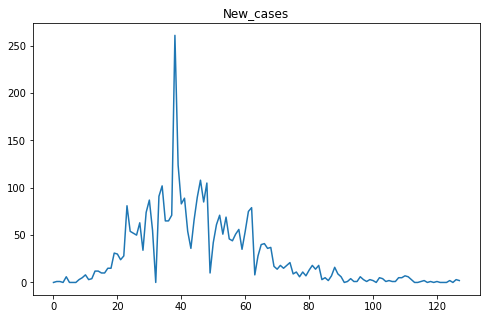

In [7]:
df['y'].plot(figsize=(8,5))
plt.title(compart)
plt.show()

In [66]:
prediction_size = 14
train_df = df[:-prediction_size]

In [9]:
m = Prophet()
_ = m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=prediction_size)

In [11]:
forecast = m.predict(future)

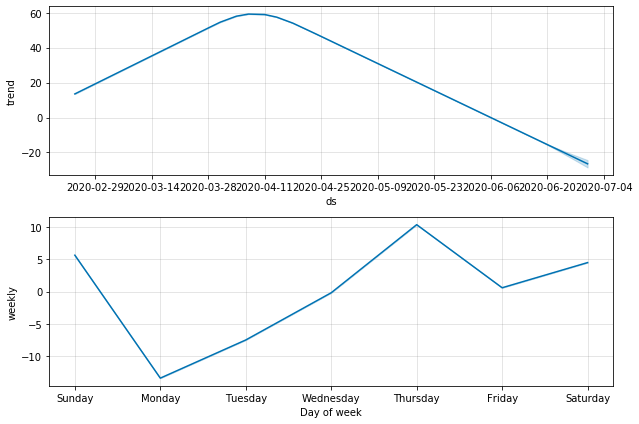

In [12]:
m.plot_components(forecast)
plt.show()

In [13]:
y_true = df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_true, y_pred, squared=True)
print('MSE: %.3f' % mse)

rmse = mean_squared_error(y_true, y_pred, squared=False)
print('RMSE: %.3f' % rmse)

MAE: 17.221
MSE: 687.324
RMSE: 26.217


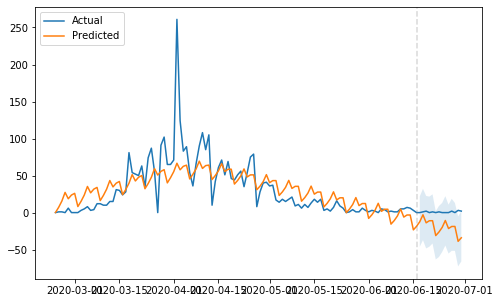

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(df['ds'], y_true, label='Actual')
plt.plot(df['ds'], y_pred, label='Predicted')
plt.fill_between(df[-prediction_size:]['ds'], forecast.yhat_lower[-prediction_size:], forecast.yhat_upper[-prediction_size:], alpha=.15)
plt.axvline(train_df.iloc[-1]['ds'], linestyle='dashed', color='grey', alpha=0.3)
plt.legend()
plt.show()

In [28]:
import itertools
import numpy as np
import pandas as pd

from fbprophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='80 days', horizon='14 days', period='14 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8ce80dfe20>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8ce80ed550>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet wit

In [29]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [30]:
m = Prophet(**best_params)
_ = m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
y_true = df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_true, y_pred, squared=True)
print('MSE: %.3f' % mse)

rmse = mean_squared_error(y_true, y_pred, squared=False)
print('RMSE: %.3f' % rmse)

MAE: 10.202
MSE: 424.038
RMSE: 20.592


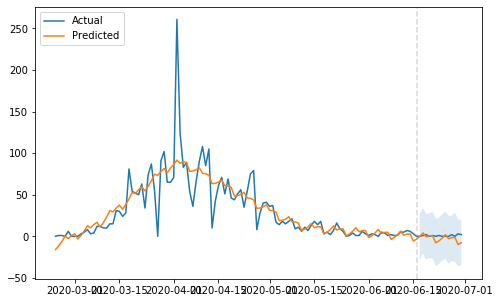

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(df['ds'], y_true, label='Actual')
plt.plot(df['ds'], y_pred, label='Predicted')
plt.fill_between(df[-prediction_size:]['ds'], forecast.yhat_lower[-prediction_size:], forecast.yhat_upper[-prediction_size:], alpha=.15)
plt.axvline(train_df.iloc[-1]['ds'], linestyle='dashed', color='grey', alpha=0.3)
plt.legend()
plt.show()

### Deaths

In [5]:
province = "Firenze"
compart = "Deaths"
date = 'Date'

In [6]:
df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')
df = df.loc[:, ['Date', compart]]
df.columns = ['ds', 'y']
df.reset_index(inplace=True, drop=True)

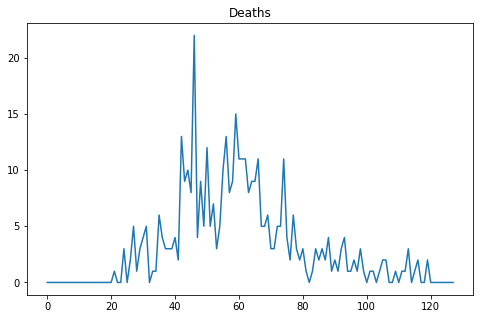

In [7]:
df['y'].plot(figsize=(8,5))
plt.title(compart)
plt.show()

In [8]:
prediction_size = 14
train_df = df[:-prediction_size]

In [9]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='80 days', horizon='14 days', period='14 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f647a84ad00>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6469f678e0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet wit

In [10]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [11]:
m = Prophet(**best_params)
_ = m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
y_true = df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_true, y_pred, squared=True)
print('MSE: %.3f' % mse)

rmse = mean_squared_error(y_true, y_pred, squared=False)
print('RMSE: %.3f' % rmse)

MAE: 1.889
MSE: 6.931
RMSE: 2.633


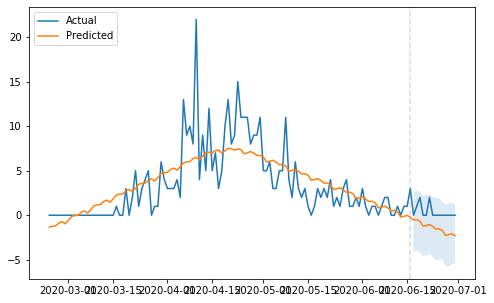

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(df['ds'], y_true, label='Actual')
plt.plot(df['ds'], y_pred, label='Predicted')
plt.fill_between(df[-prediction_size:]['ds'], forecast.yhat_lower[-prediction_size:], forecast.yhat_upper[-prediction_size:], alpha=.15)
plt.axvline(train_df.iloc[-1]['ds'], linestyle='dashed', color='grey', alpha=0.3)
plt.legend()
plt.show()

## Regional

### New cases (aka: nuovi_positivi)

In [5]:
province = "Lombardia"
compart = "nuovi_positivi"
date = 'data'

In [6]:
df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province].query('20200701 > data')
df = df.loc[:, ['data', compart]]
df.columns = ['ds', 'y']
df.reset_index(inplace=True, drop=True)

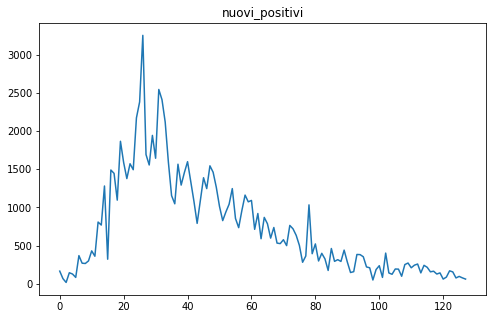

In [7]:
df['y'].plot(figsize=(8,5))
plt.title(compart)
plt.show()

In [8]:
prediction_size = 14
train_df = df[:-prediction_size]

In [9]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='80 days', horizon='14 days', period='14 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f69a0ce2430>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f69b1dd2ca0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

In [10]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [11]:
m = Prophet(**best_params)
_ = m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
y_true = df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_true, y_pred, squared=True)
print('MSE: %.3f' % mse)

rmse = mean_squared_error(y_true, y_pred, squared=False)
print('RMSE: %.3f' % rmse)

MAE: 154.581
MSE: 51532.572
RMSE: 227.008


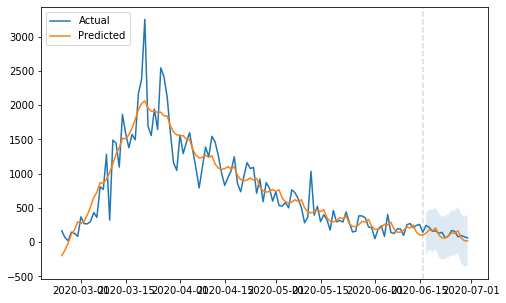

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(df['ds'], y_true, label='Actual')
plt.plot(df['ds'], y_pred, label='Predicted')
plt.fill_between(df[-prediction_size:]['ds'], forecast.yhat_lower[-prediction_size:], forecast.yhat_upper[-prediction_size:], alpha=.15)
plt.axvline(train_df.iloc[-1]['ds'], linestyle='dashed', color='grey', alpha=0.3)
plt.legend()
plt.show()